In [32]:
import numpy as np
import pandas as pd
from pgmpy.models import BayesianNetwork
from pgmpy.sampling import BayesianModelSampling
from sklearn.linear_model import LinearRegression

# Define the Bayesian Network
model = BayesianNetwork([('asia', 'tub'), ('smoke', 'lung'), ('smoke', 'bronc'), 
                         ('lung', 'either'), ('tub', 'either'), 
                         ('either', 'xray'), ('either', 'dysp'), ('bronc', 'dysp')])

# Define the CPDs
from pgmpy.factors.discrete import TabularCPD

cpd_asia = TabularCPD(variable='asia', variable_card=2, values=[[0.01], [0.99]])
cpd_tub = TabularCPD(variable='tub', variable_card=2, 
                     values=[[0.05, 0.01], [0.95, 0.99]],
                     evidence=['asia'], evidence_card=[2])
cpd_smoke = TabularCPD(variable='smoke', variable_card=2, values=[[0.5], [0.5]])
cpd_lung = TabularCPD(variable='lung', variable_card=2, 
                      values=[[0.1, 0.01], [0.9, 0.99]],
                      evidence=['smoke'], evidence_card=[2])
cpd_bronc = TabularCPD(variable='bronc', variable_card=2, 
                       values=[[0.6, 0.3], [0.4, 0.7]],
                       evidence=['smoke'], evidence_card=[2])
cpd_either = TabularCPD(variable='either', variable_card=2,
                        values=[[1, 1, 1, 0], [0, 0, 0, 1]],
                        evidence=['lung', 'tub'], evidence_card=[2, 2])
cpd_xray = TabularCPD(variable='xray', variable_card=2, 
                      values=[[0.98, 0.05], [0.02, 0.95]],
                      evidence=['either'], evidence_card=[2])
cpd_dysp = TabularCPD(variable='dysp', variable_card=2, 
                      values=[[0.9, 0.7, 0.8, 0.1], [0.1, 0.3, 0.2, 0.9]],
                      evidence=['bronc', 'either'], evidence_card=[2, 2])


In [33]:
import numpy as np
import pandas as pd
from pgmpy.models import BayesianNetwork
from pgmpy.sampling import BayesianModelSampling
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# Add CPDs to the model
model.add_cpds(cpd_asia, cpd_tub, cpd_smoke, cpd_lung, cpd_bronc, cpd_either, cpd_xray, cpd_dysp)

# Check if the model is valid
assert model.check_model()

# Sample data
sampler = BayesianModelSampling(model)
data_large = sampler.forward_sample(size=10000)
data_train, data_valid = train_test_split(data_large, train_size=1000, test_size=1000, random_state=42)

# Prepare data for models
# For data_train
X = data_train[['asia', 'smoke', 'lung', 'bronc']]  # Covariates
T = data_train['either']  # Treatment
Y = data_train['dysp']  # Outcome

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# For data_valid
X_valid = data_valid[['asia', 'smoke', 'lung', 'bronc']]  # Covariates
T_valid = data_valid['either']  # Treatment
Y_valid = data_valid['dysp']  # Outcome

scaler = StandardScaler()
X_valid = scaler.fit_transform(X_valid)


Generating for node: dysp: 100%|██████████| 8/8 [00:00<00:00, 208.03it/s]
/data1/bubble3jh/anaconda3/envs/cet/lib/python3.10/site-packages/pgmpy/sampling/base.py:598: FutureWarning: Passing a DataFrame to DataFrame.from_records is deprecated. Use set_index and/or drop to modify the DataFrame instead.
  df = pd.DataFrame.from_records(samples)


In [45]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

# Assuming data is already prepared
# X: covariates, T: treatment, Y: outcome
# data_large: large dataset for true effect calculation
# data_small: small dataset for model training and evaluation

# Dataset class for PyTorch models
class CausalDataset(Dataset):
    def __init__(self, X, T, Y):
        self.X = torch.FloatTensor(X)
        self.T = torch.FloatTensor(T.values)
        self.Y = torch.FloatTensor(Y.values)
        
    def __len__(self):
        return len(self.Y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.T[idx], self.Y[idx]

dataset = CausalDataset(X_scaled, T, Y)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Linear Model
def train_linear():
    model = LinearRegression()
    model.fit(np.column_stack((X_scaled, T)), Y)
    return model

# Ridge Model
def train_ridge():
    model = Ridge(alpha=1.0)
    model.fit(np.column_stack((X_scaled, T)), Y)
    return model

# MLP Model
def train_mlp():
    model = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000)
    model.fit(np.column_stack((X_scaled, T)), Y)
    return model

# TARNet Model
class TARNet(nn.Module):
    def __init__(self, input_dim):
        super(TARNet, self).__init__()
        self.shared = nn.Sequential(
            nn.Linear(input_dim, 200),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU()
        )
        self.t1 = nn.Linear(100, 1)
        self.t0 = nn.Linear(100, 1)
        
    def forward(self, x, t):
        h = self.shared(x)
        return torch.where(t.unsqueeze(1) == 1, self.t1(h), self.t0(h))

def train_tarnet(dataloader):
    model = TARNet(X_scaled.shape[1])
    optimizer = optim.Adam(model.parameters())
    loss_fn = nn.MSELoss()
    
    for epoch in range(100):
        for x, t, y in dataloader:
            optimizer.zero_grad()
            y_pred = model(x, t)
            loss = loss_fn(y_pred, y.unsqueeze(1))
            loss.backward()
            optimizer.step()
    
    return model

# DragonNet Model
class DragonNet(nn.Module):
    def __init__(self, input_dim):
        super(DragonNet, self).__init__()
        self.shared = nn.Sequential(
            nn.Linear(input_dim, 200),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU()
        )
        self.t1 = nn.Linear(100, 1)
        self.t0 = nn.Linear(100, 1)
        self.prop = nn.Linear(100, 1)
        
    def forward(self, x):
        h = self.shared(x)
        t1 = self.t1(h)
        t0 = self.t0(h)
        prop = torch.sigmoid(self.prop(h))
        return t1, t0, prop

def train_dragonnet(dataloader):
    model = DragonNet(X_scaled.shape[1])
    optimizer = optim.Adam(model.parameters())
    loss_fn = nn.BCELoss()
    
    for epoch in range(100):
        for x, t, y in dataloader:
            optimizer.zero_grad()
            t1, t0, prop = model(x)
            loss = loss_fn(prop, t.unsqueeze(1)) + \
                   ((t.unsqueeze(1) * (y.unsqueeze(1) - t1) ** 2 + 
                    (1 - t.unsqueeze(1)) * (y.unsqueeze(1) - t0) ** 2)).mean()
            loss.backward()
            optimizer.step()
    
    return model

# CEVAE Model (simplified version)
class CEVAE(nn.Module):
    def __init__(self, input_dim, latent_dim=10, hidden_dim=20):
        super(CEVAE, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        
        # Encoder networks
        self.encoder_x = nn.Sequential(
            nn.Linear(input_dim, hidden_dim * 2),
            nn.ReLU(),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU()
        )
        self.encoder_t = nn.Linear(hidden_dim, 1)
        self.encoder_y0 = nn.Linear(hidden_dim, 1)
        self.encoder_y1 = nn.Linear(hidden_dim, 1)
        self.encoder_z = nn.Sequential(
            nn.Linear(hidden_dim + 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_var = nn.Linear(hidden_dim, latent_dim)
        
        # Decoder networks
        self.decoder_z = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.decoder_t = nn.Linear(hidden_dim, 1)
        self.decoder_y0 = nn.Linear(hidden_dim, 1)
        self.decoder_y1 = nn.Linear(hidden_dim, 1)
        self.decoder_x = nn.Sequential(
            nn.Linear(hidden_dim + 2, hidden_dim * 2),
            nn.ReLU(),
            nn.Linear(hidden_dim * 2, input_dim)
        )
    
    def encode(self, x, t, y):
        h = self.encoder_x(x)
        t_pred = torch.sigmoid(self.encoder_t(h))
        y_pred = torch.where(t.unsqueeze(1) > 0.5, 
                             self.encoder_y1(h), 
                             self.encoder_y0(h))
        z_input = torch.cat([h, t_pred, y_pred], dim=1)
        z_h = self.encoder_z(z_input)
        return self.fc_mu(z_h), self.fc_var(z_h)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        h = self.decoder_z(z)
        t_pred = torch.sigmoid(self.decoder_t(h))
        y_pred = torch.where(t_pred > 0.5, 
                             self.decoder_y1(h), 
                             self.decoder_y0(h))
        x_input = torch.cat([h, t_pred, y_pred], dim=1)
        x_recon = self.decoder_x(x_input)
        return x_recon, t_pred, y_pred
    
    def forward(self, x, t, y):
        mu, logvar = self.encode(x, t, y)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

def train_cevae(dataloader):
    model = CEVAE(next(iter(dataloader))[0].shape[1])
    optimizer = torch.optim.Adam(model.parameters())
    
    for epoch in range(100):
        for x, t, y in dataloader:
            optimizer.zero_grad()
            (x_recon, t_pred, y_pred), mu, logvar = model(x, t, y)
            
            # Reconstruction loss
            recon_loss = F.mse_loss(x_recon, x) + \
                         F.binary_cross_entropy(t_pred, t.unsqueeze(1)) + \
                         F.mse_loss(y_pred, y.unsqueeze(1))
            
            # KL divergence
            kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            
            # Total loss
            loss = recon_loss + kl_div
            
            loss.backward()
            optimizer.step()
    
    return model

# Train all models
linear_model = train_linear()
ridge_model = train_ridge()
mlp_model = train_mlp()
tarnet_model = train_tarnet(dataloader)
dragonnet_model = train_dragonnet(dataloader)
cevae_model = train_cevae(dataloader)

# Function to calculate true effect
def true_effect(data):
    effect_1 = data[data['either'] == 1]['dysp'].mean()
    effect_0 = data[data['either'] == 0]['dysp'].mean()
    return effect_1 - effect_0

true_ate = true_effect(data_large)

# Function to calculate individual treatment effects (ITE)
def calculate_ite(model, X):
    if isinstance(model, (LinearRegression, Ridge, MLPRegressor)):
        ite = model.predict(np.column_stack((X, np.ones(len(X))))) - \
              model.predict(np.column_stack((X, np.zeros(len(X)))))
    elif isinstance(model, (TARNet, DragonNet)):
        model.eval()
        with torch.no_grad():
            X_tensor = torch.FloatTensor(X)
            if isinstance(model, TARNet):
                ite = model(X_tensor, torch.ones(len(X_tensor))) - \
                      model(X_tensor, torch.zeros(len(X_tensor)))
            else:  # DragonNet
                t1, t0, _ = model(X_tensor)
                ite = t1 - t0
            ite = ite.numpy().flatten()
    elif isinstance(model, CEVAE):
        model.eval()
        with torch.no_grad():
            X_tensor = torch.FloatTensor(X)
            T_tensor = torch.zeros(len(X_tensor))
            Y_tensor = torch.zeros(len(X_tensor))
            _, _, y0 = model(X_tensor, T_tensor, Y_tensor)[0]
            T_tensor = torch.ones(len(X_tensor))
            _, _, y1 = model(X_tensor, T_tensor, Y_tensor)[0]
            ite = (y1 - y0).numpy().flatten()
    return ite

# Calculate PEHE for all models
def calculate_pehe(true_ite, estimated_ite):
    diff = true_ite - estimated_ite
    non_nan_mask = ~np.isnan(diff)
    if non_nan_mask.sum() == 0:
        return np.nan
    return np.sqrt(np.mean(diff[non_nan_mask]**2))

# Calculate true ITE
def calculate_true_ite(row):
    matching_rows = data_large[
        (data_large['asia'] == row['asia']) & 
        (data_large['smoke'] == row['smoke']) & 
        (data_large['lung'] == row['lung']) & 
        (data_large['bronc'] == row['bronc']) & 
        (data_large['xray'] == row['xray'])
    ]
    if len(matching_rows) > 0:
        return true_effect(matching_rows)
    else:
        return np.nan



In [46]:
def calculate_metrics(true_ite, estimated_ite):
    diff = true_ite - estimated_ite
    non_nan_mask = ~np.isnan(diff)
    if non_nan_mask.sum() == 0:
        return np.nan, np.nan
    pehe = np.sqrt(np.mean(diff[non_nan_mask]**2))
    ate = np.mean(np.abs(diff[non_nan_mask]))
    return pehe, ate

# for train dataset
true_ite = data_train.apply(calculate_true_ite, axis=1)
print(f"True ITE - shape: {true_ite.shape}, non-NaN count: {true_ite.notna().sum()}, mean: {true_ite.mean()}")

models = {
    'Linear': linear_model,
    'Ridge': ridge_model,
    'MLP': mlp_model,
    'TARNet': tarnet_model,
    'DragonNet': dragonnet_model,
    'CEVAE': cevae_model
}

results = {}
for name, model in models.items():
    estimated_ite = calculate_ite(model, X_scaled)
    pehe, ate = calculate_metrics(true_ite, estimated_ite)
    results[name] = {'PEHE': pehe, '|ATE|': ate}

print("\nTrain Results:")
for name, metrics in results.items():
    print(f"{name} - PEHE: {metrics['PEHE']:.3f}, |ATE|: {metrics['|ATE|']:.3f}")

    
print("\n")
# for valid dataset

true_ite = data_valid.apply(calculate_true_ite, axis=1)
print(f"True ITE - shape: {true_ite.shape}, non-NaN count: {true_ite.notna().sum()}, mean: {true_ite.mean()}")

models = {
    'Linear': linear_model,
    'Ridge': ridge_model,
    'MLP': mlp_model,
    'TARNet': tarnet_model,
    'DragonNet': dragonnet_model,
    'CEVAE': cevae_model
}

results = {}
for name, model in models.items():
    estimated_ite = calculate_ite(model, X_valid)
    pehe, ate = calculate_metrics(true_ite, estimated_ite)
    results[name] = {'PEHE': pehe, '|ATE|': ate}

print("\nValid Results:")
for name, metrics in results.items():
    print(f"{name} - PEHE: {metrics['PEHE']:.3f}, |ATE|: {metrics['|ATE|']:.3f}")

    

True ITE - shape: (1000,), non-NaN count: 645, mean: 0.6328119993019978

Train Results:
Linear - PEHE: 0.294, |ATE|: 0.292
Ridge - PEHE: 0.311, |ATE|: 0.302
MLP - PEHE: 0.398, |ATE|: 0.372
TARNet - PEHE: 0.087, |ATE|: 0.064
DragonNet - PEHE: 0.072, |ATE|: 0.038
CEVAE - PEHE: 0.699, |ATE|: 0.633


True ITE - shape: (1000,), non-NaN count: 605, mean: 0.6260474340093796

Valid Results:
Linear - PEHE: 0.296, |ATE|: 0.293
Ridge - PEHE: 0.311, |ATE|: 0.301
MLP - PEHE: 0.398, |ATE|: 0.369
TARNet - PEHE: 0.103, |ATE|: 0.074
DragonNet - PEHE: 0.093, |ATE|: 0.048
CEVAE - PEHE: 0.694, |ATE|: 0.628


In [24]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from itertools import product

def create_cevae_model(input_dim, latent_dim, hidden_dim):
    return CEVAE(input_dim, latent_dim, hidden_dim)

def train_cevae(model, dataloader, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        for x, t, y in dataloader:
            optimizer.zero_grad()
            (x_recon, t_pred, y_pred), mu, logvar = model(x, t, y)
            
            recon_loss = nn.MSELoss()(x_recon, x) + \
                         nn.BCELoss()(t_pred, t.unsqueeze(1)) + \
                         nn.MSELoss()(y_pred, y.unsqueeze(1))
            
            kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            
            loss = recon_loss + kl_div
            loss.backward()
            optimizer.step()
    return model

def evaluate_cevae(model, X, T, Y, true_ite):
    model.eval()
    with torch.no_grad():
        X_tensor = torch.FloatTensor(X)
        T_tensor = torch.FloatTensor(T)
        Y_tensor = torch.FloatTensor(Y)
        
        _, _, y0 = model(X_tensor, torch.zeros_like(T_tensor), Y_tensor)[0]
        _, _, y1 = model(X_tensor, torch.ones_like(T_tensor), Y_tensor)[0]
        
        estimated_ite = (y1 - y0).numpy().flatten()
    
    pehe = calculate_pehe(true_ite, estimated_ite)
    return pehe

def hyperparameter_tuning_cevae(X, T, Y, true_ite):
    # Define hyperparameter grid
    latent_dims = [10, 20, 30]
    hidden_dims = [50, 100, 200]
    learning_rates = [1e-3, 1e-4]
    batch_sizes = [32, 64]
    num_epochs_list = [100]
    weight_decays = [0, 1e-5, 1e-4, 1e-3]  # Added weight decay values
    
    results = []
    
    # Create dataset
    dataset = TensorDataset(torch.FloatTensor(X), torch.FloatTensor(T), torch.FloatTensor(Y))
    
    for latent_dim, hidden_dim, lr, batch_size, num_epochs, weight_decay in product(
        latent_dims, hidden_dims, learning_rates, batch_sizes, num_epochs_list, weight_decays
    ):
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        
        model = create_cevae_model(X.shape[1], latent_dim, hidden_dim)
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)  # Added weight_decay
        
        trained_model = train_cevae(model, dataloader, optimizer, num_epochs)
        pehe = evaluate_cevae(trained_model, X, T, Y, true_ite)
        
        results.append({
            'latent_dim': latent_dim,
            'hidden_dim': hidden_dim,
            'learning_rate': lr,
            'batch_size': batch_size,
            'num_epochs': num_epochs,
            'weight_decay': weight_decay,  # Added weight_decay to results
            'pehe': pehe
        })
        
        print(f"Latent dim: {latent_dim}, Hidden dim: {hidden_dim}, LR: {lr}, "
              f"Batch size: {batch_size}, Epochs: {num_epochs}, "
              f"Weight decay: {weight_decay}, PEHE: {pehe}")
    
    # Sort results by PEHE
    results.sort(key=lambda x: x['pehe'])
    
    return results

# Usage
best_hyperparameters = hyperparameter_tuning_cevae(X_scaled, T, Y, true_ite)

print("\nBest Hyperparameters:")
print(best_hyperparameters[0])

# Train the best model
best_params = best_hyperparameters[0]
best_model = create_cevae_model(X_scaled.shape[1], best_params['latent_dim'], best_params['hidden_dim'])
best_dataloader = DataLoader(TensorDataset(torch.FloatTensor(X_scaled), torch.FloatTensor(T), torch.FloatTensor(Y)), 
                             batch_size=best_params['batch_size'], shuffle=True)
best_optimizer = optim.Adam(best_model.parameters(), lr=best_params['learning_rate'], 
                            weight_decay=best_params['weight_decay'])  # Added weight_decay
best_cevae_model = train_cevae(best_model, best_dataloader, best_optimizer, best_params['num_epochs'])

# Evaluate the best model
final_pehe = evaluate_cevae(best_cevae_model, X_scaled, T, Y, true_ite)
print(f"\nFinal PEHE with best hyperparameters: {final_pehe}")

Latent dim: 10, Hidden dim: 50, LR: 0.001, Batch size: 32, Epochs: 100, Weight decay: 0, PEHE: 0.6833815750333201
Latent dim: 10, Hidden dim: 50, LR: 0.001, Batch size: 32, Epochs: 100, Weight decay: 1e-05, PEHE: 0.6823818198082046
Latent dim: 10, Hidden dim: 50, LR: 0.001, Batch size: 32, Epochs: 100, Weight decay: 0.0001, PEHE: 0.6792067363039095
Latent dim: 10, Hidden dim: 50, LR: 0.001, Batch size: 32, Epochs: 100, Weight decay: 0.001, PEHE: 0.6838388594783691
Latent dim: 10, Hidden dim: 50, LR: 0.001, Batch size: 64, Epochs: 100, Weight decay: 0, PEHE: 0.6830664061189445
Latent dim: 10, Hidden dim: 50, LR: 0.001, Batch size: 64, Epochs: 100, Weight decay: 1e-05, PEHE: 0.6827767618558899
Latent dim: 10, Hidden dim: 50, LR: 0.001, Batch size: 64, Epochs: 100, Weight decay: 0.0001, PEHE: 0.6832116135240752
Latent dim: 10, Hidden dim: 50, LR: 0.001, Batch size: 64, Epochs: 100, Weight decay: 0.001, PEHE: 0.6823526082041612
Latent dim: 10, Hidden dim: 50, LR: 0.0001, Batch size: 32, Ep

KeyboardInterrupt: 

Working for n conditional variables: 0:   0%|          | 0/24 [00:00<?, ?it/s]/data1/bubble3jh/anaconda3/envs/cet/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
Working for n conditional variables: 9:  38%|███▊      | 9/24 [00:16<00:27,  1.82s/it]


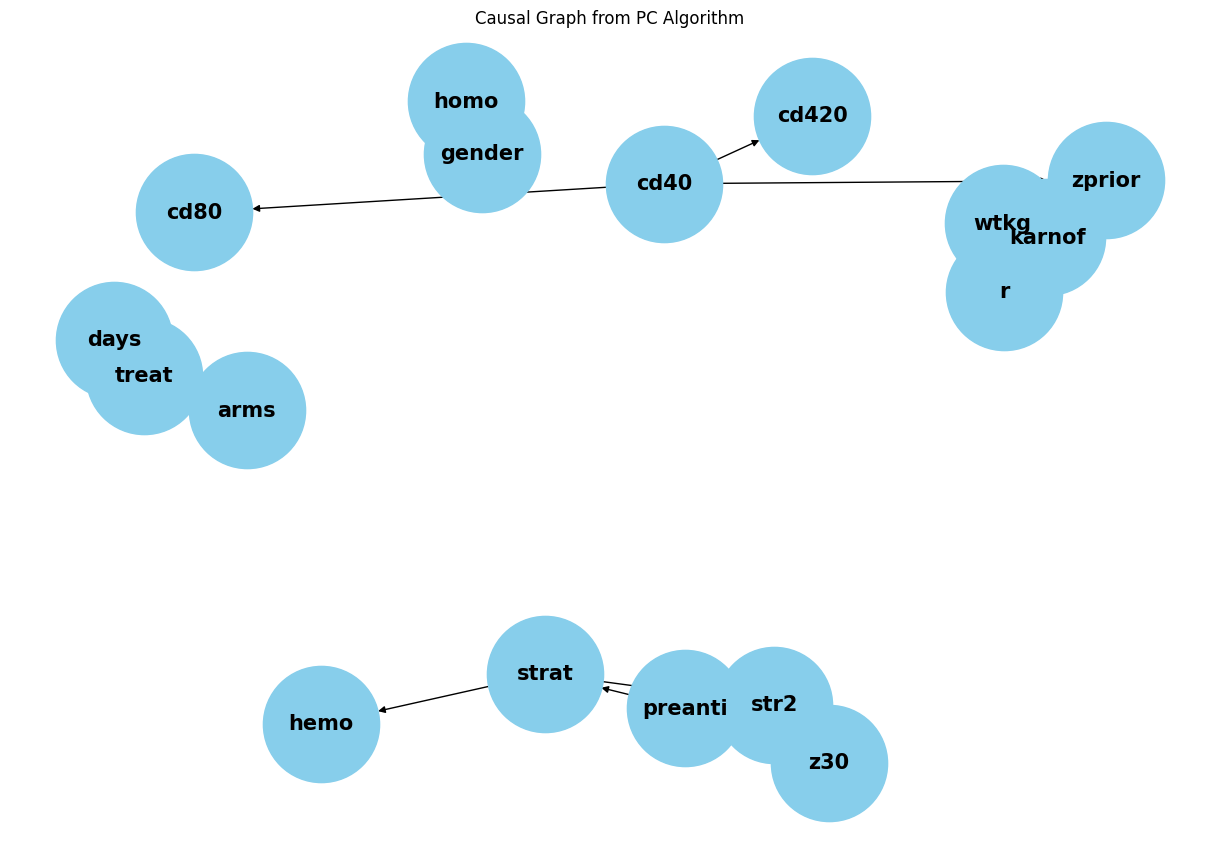

In [7]:
import networkx as nx
import matplotlib.pyplot as plt
from pgmpy.estimators import PC
from pgmpy.estimators import BicScore

# Define the PC algorithm estimator
actg175_data = pd.read_csv('/data1/bubble3jh/cluster-regression/synthetic/actg175.csv')
pc_estimator = PC(data=actg175_data)

# Perform causal discovery to find the skeleton and CPDAG
cpdag = pc_estimator.estimate(return_type="cpdag", significance_level=0.05,
                              max_cond_vars=len(actg175_data.columns) - 1, ci_test="pearsonr")

# Convert the CPDAG to a networkx graph
G = nx.DiGraph()
G.add_edges_from(cpdag.edges())

# Draw the graph
plt.figure(figsize=(12, 8))  # Set the size of the plot
pos = nx.spring_layout(G)  # positions for all nodes
nx.draw(G, pos, with_labels=True, node_size=700, node_color='skyblue', font_size=15, font_weight='bold')
plt.title('Causal Graph from PC Algorithm')
plt.show()


Working for n conditional variables: 7:  88%|████████▊ | 7/8 [00:01<00:00,  3.57it/s]


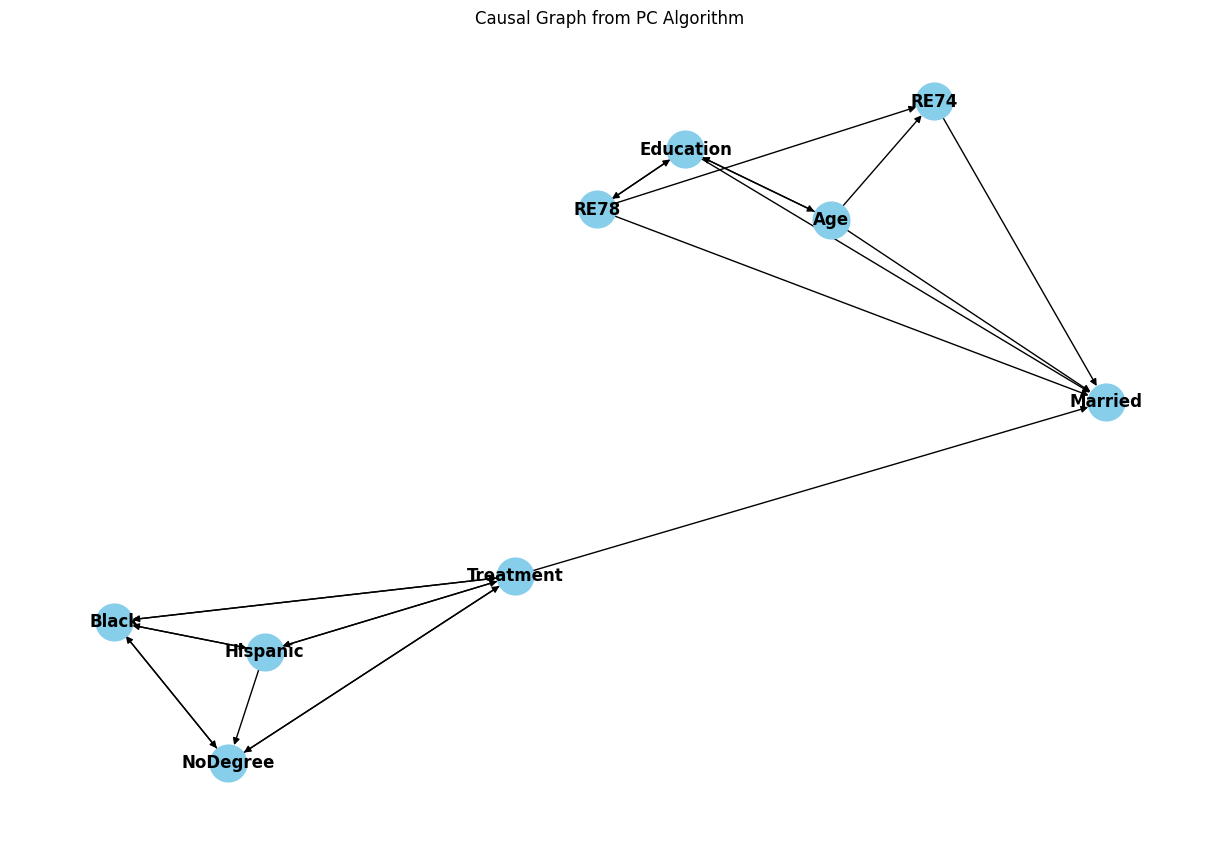

In [18]:
import networkx as nx
import matplotlib.pyplot as plt
from pgmpy.estimators import PC
from pgmpy.estimators import BicScore

# Define the PC algorithm estimator
actg175_data = pd.read_csv('/data1/bubble3jh/cluster-regression/synthetic/Jobs_Lalonde_Data.csv')
pc_estimator = PC(data=actg175_data)

# Perform causal discovery to find the skeleton and CPDAG
cpdag = pc_estimator.estimate(return_type="cpdag", significance_level=0.05,
                              max_cond_vars=len(actg175_data.columns) - 1, ci_test="pearsonr")

# Convert the CPDAG to a networkx graph
G = nx.DiGraph()
G.add_edges_from(cpdag.edges())

# Draw the graph
plt.figure(figsize=(12, 8))  # Set the size of the plot
pos = nx.spring_layout(G)  # positions for all nodes
nx.draw(G, pos, with_labels=True, node_size=700, node_color='skyblue', font_size=12, font_weight='bold')
plt.title('Causal Graph from PC Algorithm')
plt.show()


In [25]:
import csv
import pandas as pd
from sklearn.model_selection import train_test_split
import pyreadr
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
import numpy as np

def read_START_data(q_prime=0.1):
    result = pyreadr.read_r('/data1/bubble3jh/cluster-regression/synthetic/STAR_Students.RData')
    
    dat = result['x']
    df = dat
    
    #Drop nans
    treatment_indicator = df['g1classtype'].notna()
    df = df[treatment_indicator]
    
    #Only consider regular and small classes
    reg_size = df['g1classtype']=='REGULAR CLASS'
    small_size = df['g1classtype']=='SMALL CLASS'
    size_indicator = reg_size|small_size
    df = df[size_indicator]
     
    #Remove students with missing outcome 
    df = df[df['g1tlistss'].notna()]
    df.shape
    
    df = df[df['g1treadss'].notna()]
    df.shape
    
    df = df[df['g1tmathss'].notna()]
    df.shape
    
    #Treatment and outcome variables
    df['treatment'] = (df['g1classtype']=='SMALL CLASS').astype(int)
    df['outcome'] = df['g1tlistss'] + df['g1treadss'] + df['g1tmathss']
    df['rural'] = (df['g1surban'] == 'RURAL') | (df['g1surban'] == 'INNER CITY')
    
    #Only use covariates: gender, race, birth month, birthday, birth year, free lunch given or not, teacher id
    df_all = df[['outcome', 'treatment', 'gender', 'race', 'birthmonth', 'birthday', 'birthyear', 'g1freelunch', 'g1tchid', 'rural']]
    
    #Remove students with missing covariates
    for i in ['gender', 'race', 'birthmonth', 'birthday', 'birthyear', 'g1freelunch', 'g1tchid', 'rural']:
        df_all = df_all[df_all[i].notna()]
        df = df[df[i].notna()]
    
    #Ordinal transformer
    for i in ['gender', 'race', 'birthmonth', 'g1freelunch', 'rural']:
        enc = OrdinalEncoder(dtype=int)
        x = np.array(df_all[i].values).reshape(-1,1)
        enc.fit(x)
        x_transform = enc.transform(x)
        df_all[i] = x_transform
    
    #Center/scale data
    scaler = StandardScaler()
    scaler.fit(df_all[['birthday', 'birthyear', 'g1tchid', 'outcome']].values)
    df_all[['birthday', 'birthyear', 'g1tchid', 'outcome']] = scaler.transform(df_all[['birthday', 'birthyear', 'g1tchid', 'outcome']])

    rct_indicator1 = (df_all['birthday'] < 0)*np.random.binomial(1, 0.5, df_all['birthday'].shape[0]) + (df_all['birthday'] >= 0)*np.random.binomial(1, 0.1, df_all['birthday'].shape[0])
    
    rct_indicator = (rct_indicator1)>0
    
    df_RCT = df_all[rct_indicator==1]
    df_OS = df_all[rct_indicator==0]

    indicator = df_OS['treatment'] == 0 
    df_OS_control = df_OS[indicator]
    
    #Introduce confounding
    indicator = df_OS['treatment'] == 1
    df_OS_treated = df_OS[indicator]
    mean = df_OS_treated['outcome'].mean() 
    std = df_OS_treated['outcome'].std() 
    indicator_treat =  df_OS_treated['outcome'] > mean+std
    

    indicator_control =  df_OS_control['outcome'] < mean-std
    
    df_OS_treated_upper_half = df_OS_treated[indicator_treat]
    
    df_OS_control_lower_half = df_OS_control[indicator_control]    
    
    df_unc = df_RCT
    df_conf = pd.concat((df_OS_control_lower_half,
                         df_OS_treated_upper_half))
    
    def create_multi_treatment_data(df_OS):
        # df_OS의 복사본 생성
        df_multi = df_OS.copy()
        
        # rural을 indirect_treatment로, treatment를 direct_treatment로 변경
        df_multi['indirect_treatment'] = df_multi['rural']
        df_multi.rename(columns={'treatment': 'direct_treatment'}, inplace=True)
        
        # 데이터를 4개의 그룹으로 나눔
        group_00 = df_multi[(df_multi['indirect_treatment'] == 0) & (df_multi['direct_treatment'] == 0)]
        group_01 = df_multi[(df_multi['indirect_treatment'] == 0) & (df_multi['direct_treatment'] == 1)]
        group_10 = df_multi[(df_multi['indirect_treatment'] == 1) & (df_multi['direct_treatment'] == 0)]
        group_11 = df_multi[(df_multi['indirect_treatment'] == 1) & (df_multi['direct_treatment'] == 1)]
        
        # 각 그룹의 크기 계산
        n_00 = len(group_00)
        n_01 = len(group_01)
        n_10 = len(group_10)
        n_11 = len(group_11)
        
        # 목표 비율 설정
        target_ratio = 0.7 / 0.3
        
        # 새로운 그룹 크기 계산
        new_n_00 = min(n_00, int(n_11 * target_ratio))
        new_n_11 = min(n_11, int(n_00 / target_ratio))
        new_n_01 = min(n_01, int(new_n_00 * 0.3 / 0.7))
        new_n_10 = min(n_10, int(new_n_11 * 0.3 / 0.7))
        
        # 각 그룹에서 무작위 샘플링
        new_group_00 = group_00.sample(new_n_00, random_state=42)
        new_group_01 = group_01.sample(new_n_01, random_state=42)
        new_group_10 = group_10.sample(new_n_10, random_state=42)
        new_group_11 = group_11.sample(new_n_11, random_state=42)
        
        # 새로운 데이터프레임 생성
        df_multi_new = pd.concat([new_group_00, new_group_01, new_group_10, new_group_11])
        
        # x, t, y 배열 생성
        x_multi = np.array(df_multi_new.drop(['outcome', 'direct_treatment', 'indirect_treatment', 'rural'], axis=1).values, dtype='float64')
        t_multi = np.array(df_multi_new[['indirect_treatment', 'direct_treatment']].values, dtype='float64')
        y_multi = np.array(df_multi_new['outcome'].values.reshape(-1,1), dtype='float64')
        
        return {
            'x_multi': x_multi,
            't_multi': t_multi,
            'y_multi': y_multi
        }

    # multi_treat 데이터 생성
    multi_treat_data = create_multi_treatment_data(df_OS)
        
    x_multi = multi_treat_data['x_multi']
    t_multi = multi_treat_data['t_multi']
    y_multi = multi_treat_data['y_multi']
    
    #Unconfouded data
    x_unc = np.array(df_unc.values[:, 2:], dtype = 'float64')
    t_unc = np.array(df_unc['treatment'].values.reshape(-1,1), dtype = 'float64')
    y_unc = np.array(df_unc['outcome'].values.reshape(-1,1), dtype = 'float64')
    
    #Confounded data   
    x_conf = np.array(df_conf.values[:, 2:], dtype = 'float64')
    t_conf = np.array(df_conf['treatment'].values.reshape(-1,1), dtype = 'float64')
    y_conf = np.array(df_conf['outcome'].values.reshape(-1,1), dtype = 'float64')
    
    #Test on ALL\Unc  
    df_test = df_all[~df_all.isin(df_unc)].dropna()
    
    x_test = np.array(df_test.values[:, 2:], dtype = 'float64')
    t_test = np.array(df_test['treatment'].values.reshape(-1,1), dtype = 'float64')
    y_test = np.array(df_test['outcome'].values.reshape(-1,1), dtype = 'float64')
    
    #all
    x_all = np.array(df_all.values[:, 2:], dtype = 'float64')
    t_all = np.array(df_all['treatment'].values.reshape(-1,1), dtype = 'float64')
    y_all = np.array(df_all['outcome'].values.reshape(-1,1), dtype = 'float64')
    
    
    return {'x_unc': x_unc, 't_unc': t_unc, 'y_unc': y_unc, 'x_conf': x_conf, 't_conf': t_conf, 'y_conf': y_conf, 'x_test': x_test, 't_test': t_test, 'y_test': y_test, 'x_all': x_all, 't_all': t_all, 'y_all': y_all, 'x_multi': x_multi, 't_multi': t_multi, 'y_multi': y_multi,}

df = read_START_data()

/data1/bubble3jh/anaconda3/envs/cet/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [28]:
df['x_multi'].shape

(1141, 7)